In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import networkx as nx
import geopandas as gpd
import eurostat
import requests
import urllib.parse
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from matplotlib.colors import ListedColormap
from itertools import count
import matplotlib as mpl

In [3]:
shapefile_data = gpd.read_file("/Users/joebacchus/Desktop/Bartlett CASA/NUTS Shapefiles/NUTS_RG_20M_2021_3035.shp")
citations_data = pd.read_csv("/Users/joebacchus/Desktop/Bartlett CASA/Data Original/Citation data/202001_PCT_CITATIONS.txt", sep="|")
patents_data = pd.read_csv("/Users/joebacchus/Desktop/Bartlett CASA/Data Original/Patent data/202001_PCT_Inv_reg.txt", sep="|")
associated_IPC = pd.read_csv("/Users/joebacchus/Desktop/Bartlett CASA/Data Original/Patent data/202001_PCT_IPC.txt", sep="|")
IPC_translations = pd.read_csv("/Users/joebacchus/Desktop/Bartlett CASA/All_IPC.txt", sep="	")

In [243]:
# Restricting to UK and selected NUTS
NUTS_level = 3
space_GB = shapefile_data.loc[shapefile_data['CNTR_CODE'] == "UK"] # Can modify UK
space_GB = shapefile_data
space_GB_NUTS = space_GB.loc[shapefile_data['LEVL_CODE'] == NUTS_level]
space_GB_NUTS

,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
322,DE254,3,DE,"Nürnberg, Kreisfreie Stadt","Nürnberg, Kreisfreie Stadt",4.0,1,3,DE254,"POLYGON ((4395582.127 2936362.696, 4406400.516..."
323,DE255,3,DE,"Schwabach, Kreisfreie Stadt","Schwabach, Kreisfreie Stadt",4.0,1,3,DE255,"POLYGON ((4399487.535 2914611.100, 4399340.230..."
324,DE256,3,DE,"Ansbach, Landkreis","Ansbach, Landkreis",4.0,3,3,DE256,"POLYGON ((4371588.633 2925060.496, 4384059.306..."
325,DE257,3,DE,Erlangen-Höchstadt,Erlangen-Höchstadt,4.0,1,3,DE257,"POLYGON ((4387812.619 2962178.867, 4400140.051..."
402,DE258,3,DE,"Fürth, Landkreis","Fürth, Landkreis",4.0,1,3,DE258,"POLYGON ((4388620.345 2936169.261, 4388106.308..."
...,...,...,...,...,...,...,...,...,...,...
2004,TRC13,3,TR,Kilis,Kilis,3.0,2,2,TRC13,"POLYGON ((6747420.020 1958428.358, 6712801.038..."
2005,TRC21,3,TR,Şanlıurfa,Şanlıurfa,4.0,2,3,TRC21,"POLYGON ((6904684.585 2120354.802, 6938677.828..."
2006,TRC22,3,TR,Diyarbakır,Diyarbakır,4.0,2,3,TRC22,"POLYGON ((6989716.599 2273670.524, 6982786.486..."
2007,NO0B2,3,NO,Svalbard,Svalbard,3.0,3,1,NO0B2,"MULTIPOLYGON (((4754167.335 6382461.409, 47465..."


In [244]:
COUNTRY_CODE = 'GB'

# Restricting patents data to GB
GB_patents = patents_data.loc[patents_data['ctry_code'] == COUNTRY_CODE] # Can modify GB
GB_patent_ids = np.array(list(GB_patents['appln_id'])).astype(int)
GB_patents

,pct_nbr,internat_appln_nr,appln_id,inv_name,address,reg_code,ctry_code,reg_share,inv_share
2,WO1978000004,WO1978GB00001,22653861.0,"ARMITAGE, Arthur Advanced Chemical Equipment","Mirfield, West Yorkshire WF14 8BB",UKE44,GB,1.0,1.000000
4,WO1978000006,WO1978CH00002,6508282.0,"Erskine, William Graham",Morpeth Northumberland NE61 2YL,UKC21,GB,1.0,0.500000
25,WO1979000002,WO1978GB00002,22653862.0,"MARTIN, Archer, John, Porter","Elstree, Hertfordshire",UKH23,GB,1.0,0.500000
26,WO1979000002,WO1978GB00002,22653862.0,"HAMPSON, Frank","Lewes, Sussex",UKJ22,GB,1.0,0.500000
83,WO1979000070,WO1978GB00007,22653867.0,"Joseph, Simon Philip",London S.W.13,UKI11,GB,1.0,1.000000
...,...,...,...,...,...,...,...,...,...
9551495,WO2019143945,WO2019US14204,507304944.0,"NELSON, Drew",Cowbridge Vale of Glamorgan CF71 7RW,UKL22,GB,1.0,0.166667
9551562,WO2019143970,WO2019US14240,516857277.0,"FREEMAN, Toby",Nottingham NG16 6NT,UKF12,GB,1.0,0.333333
9551922,WO2019144081,WO2019US14427,507605603.0,"BRADLEY, Richard",Leicestershire LE14 4RT,UKF22,GB,1.0,0.200000
9551988,WO2019144099,WO2019US14490,507304994.0,"DROZDOV, Ignat",Warwick Warwickshire CV34 4BP,UKG13,GB,1.0,0.333333


In [245]:
associated_IPC

,pct_nbr,prio_year,app_year,IPC
0,WO2001094046,2000,2000,B21D015/10
1,WO2001094046,2000,2000,B21D026/02
2,WO2000075809,1999,2000,G06F017/30
3,WO2000075248,1999,2000,C08K005/057
4,WO2000075248,1999,2000,C09D129/04
...,...,...,...,...
12601930,WO2019062710,2017,2018,NaN
12601931,WO2009080075,2007,2007,NaN
12601932,WO2011101674,2010,2011,NaN
12601933,WO2019073271,2017,2018,NaN


In [247]:
# Restricting patents data to GB
GB_citations = citations_data[citations_data['Citing_appln_id'].isin(GB_patent_ids)]
GB_citations = pd.DataFrame(GB_citations)
GB_citations_double = GB_citations.loc[GB_citations['Cited_App_auth'] == COUNTRY_CODE] # Can modify GB
DOI = GB_citations_double[['Citing_appln_id','Citing_pub_date','Cited_Appln_id','Cited_pub_date']].astype(int)[:2000]
DOI_dates = DOI[['Citing_pub_date','Cited_pub_date']]
min_date = int(str(min(np.array(DOI_dates).flatten()))[:-4])
max_date = int(str(max(np.array(DOI_dates).flatten()))[:-4])

In [248]:
IPC_scale=1
mergeIPC = GB_patents.merge(associated_IPC, left_on='pct_nbr', right_on='pct_nbr')
mergeIPC['IPC_red'] = mergeIPC['IPC'].astype(str).str[:IPC_scale]
mergeIPC

,pct_nbr,internat_appln_nr,appln_id,inv_name,address,reg_code,ctry_code,reg_share,inv_share,prio_year,app_year,IPC,IPC_red
0,WO1978000004,WO1978GB00001,22653861.0,"ARMITAGE, Arthur Advanced Chemical Equipment","Mirfield, West Yorkshire WF14 8BB",UKE44,GB,1.0,1.000000,1977,1978,F16L047/22,F
1,WO1978000004,WO1978GB00001,22653861.0,"ARMITAGE, Arthur Advanced Chemical Equipment","Mirfield, West Yorkshire WF14 8BB",UKE44,GB,1.0,1.000000,1977,1978,F16L013/00,F
2,WO1978000004,WO1978GB00001,22653861.0,"ARMITAGE, Arthur Advanced Chemical Equipment","Mirfield, West Yorkshire WF14 8BB",UKE44,GB,1.0,1.000000,1977,1978,F16L023/024,F
3,WO1978000004,WO1978GB00001,22653861.0,"ARMITAGE, Arthur Advanced Chemical Equipment","Mirfield, West Yorkshire WF14 8BB",UKE44,GB,1.0,1.000000,1977,1978,B23P011/02,B
4,WO1978000006,WO1978CH00002,6508282.0,"Erskine, William Graham",Morpeth Northumberland NE61 2YL,UKC21,GB,1.0,0.500000,1977,1978,G03G015/22,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446193,WO2019144081,WO2019US14427,507605603.0,"BRADLEY, Richard",Leicestershire LE14 4RT,UKF22,GB,1.0,0.200000,2018,2019,G01N033/68,G
1446194,WO2019144081,WO2019US14427,507605603.0,"BRADLEY, Richard",Leicestershire LE14 4RT,UKF22,GB,1.0,0.200000,2018,2019,G01N033/70,G
1446195,WO2019144099,WO2019US14490,507304994.0,"DROZDOV, Ignat",Warwick Warwickshire CV34 4BP,UKG13,GB,1.0,0.333333,2018,2019,C12Q001/6886,C
1446196,WO2019144120,WO2019US14550,507305008.0,"FARRIMOND, Andrew",Otley Yorkshire LS211SX,UKE42,GB,1.0,0.500000,2018,2019,G06F013/40,G


In [249]:
DOI_selected = mergeIPC[['appln_id','IPC_red']][:5000]

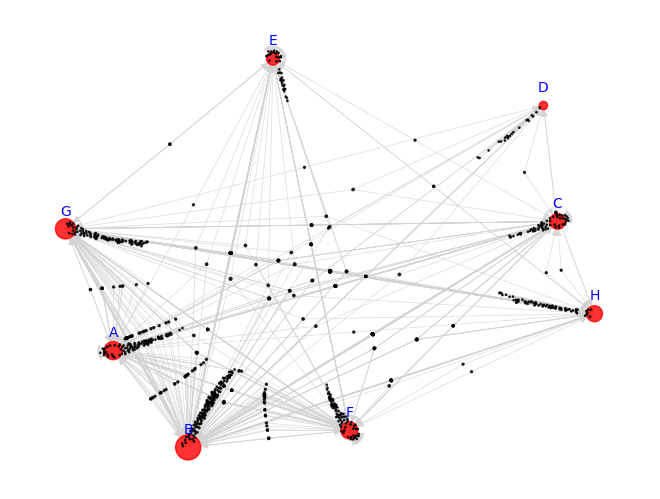

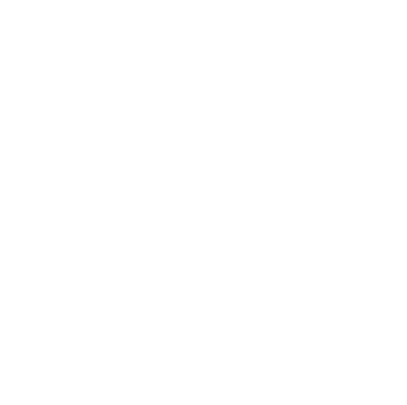

In [254]:
edge_list = np.array(DOI_selected)

graph = nx.DiGraph()
graph.add_edges_from(edge_list)

color_map = []
label_map = {}
for node in graph:
    if len(str(node)) < 2:
        color_map.append('red')
        label_map[node]= node
    else: 
        color_map.append('black')
        label_map[node]= ''

pos = nx.spring_layout(graph)

def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}

pos_nodes = nudge(pos, 0, 0.07) 

degrees = [graph.degree[node] for node in graph.nodes()]
nx.draw(graph, pos, node_size = degrees, edge_color='lightgrey', node_color=color_map, arrowsize=10, width=0.5,alpha=0.8)
nx.draw_networkx_labels(graph, pos_nodes, labels=label_map, font_size=10, font_color="blue")

plt.figure(figsize=(5,5))
plt.axis('off')
plt.show()

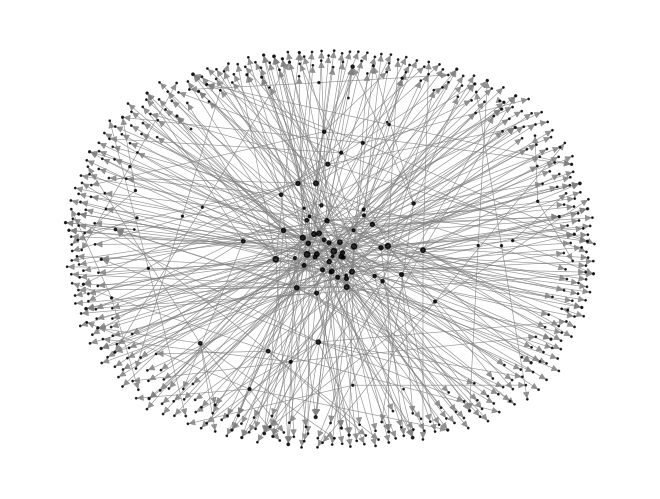

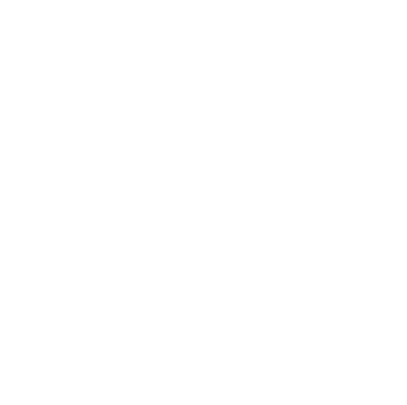

In [257]:
edge_list_2 = np.array(DOI[['Citing_pub_date','Cited_pub_date']])[:500]
graph_2 = nx.DiGraph()
graph_2.add_edges_from(edge_list_2)
pos_2 = nx.spring_layout(graph_2)
degrees = [graph_2.degree[node] for node in graph_2.nodes()]
nx.draw(graph_2, pos_2, node_size = degrees, edge_color='grey', node_color='black', arrowsize=10, width=0.5,alpha=0.8)

plt.figure(figsize=(5,5))
plt.axis('off')
plt.show()

In [115]:
# Modifiable parameters
NUTS_level = 3
IPC_level = 1

# Loading shapefile and restricting to UK and selected NUTS
space_GB = space.loc[space['CNTR_CODE'] == "UK"]
space_GB_NUTS3 = space_GB.loc[space['LEVL_CODE'] == NUTS_level]

# Restricting citations data to UK
citations_data_GB = citations_data.loc[citations_data['ctry_code'] == "GB"]

# Merging citations and shapefile
merged_data = space_GB_NUTS3.merge(citations_data_GB, left_on='FID', right_on='reg_code')

IPC_reduced = IPC_translations.loc[IPC_translations['IPC'].str.len()==IPC_level]
merged_data["IPC"] = merged_data["IPC"].str[0:IPC_level]
merged_data_named = merged_data.merge(IPC_reduced, left_on='IPC', right_on='IPC')

contents = np.sort(list(merged_data_named["IPC"].unique())) # All possible IPC
dates = np.sort(list(merged_data_named["prio_year"].unique())) # All possible IPC

In [116]:
select = 5
merged_data_named_year = merged_data_named.loc[merged_data_named['prio_year'] == dates[select]] # Full data
edge_list = np.array(merged_data_named_year[['Citing_appln_id', 'Cited_Appln_id']]) # Creating edge list
merged_data_named.loc[merged_data_named['Citing_appln_id'] == int(np.array(graph.nodes())[7])]['prio_year'].unique()

array([1980])

In [258]:
graph = nx.DiGraph()
graph.add_edges_from(edge_list)

for i in range(len(np.array(graph.nodes()))):
    graph.add_node(np.array(graph.nodes())[i], date=merged_data_named.loc[merged_data_named['Citing_appln_id'] == int(np.array(graph.nodes())[7])]['prio_year'].unique())

NameError: name 'merged_data_named' is not defined

In [160]:
plt.figure(figsize=(10,8))

groups = set(nx.get_node_attributes(graph,'date').values())
mapping = dict(zip(sorted(groups),count()))
nodes = graph.nodes()
colors = [mapping[graph.nodes[n]['date']] for n in nodes]

pos = nx.spring_layout(graph)
ec = nx.draw_networkx_edges(graph, pos, alpha=0.2, width=0.5, arrowsize=5)
nc = nx.draw_networkx_nodes(graph, pos, node_color=colors, node_size=40, cmap=plt.cm.Blues)

nc.set_edgecolor('black')
plt.colorbar(nc,shrink=0.5)
plt.axis('off')
plt.show()

KeyError: 'date'

<Figure size 1000x800 with 0 Axes>

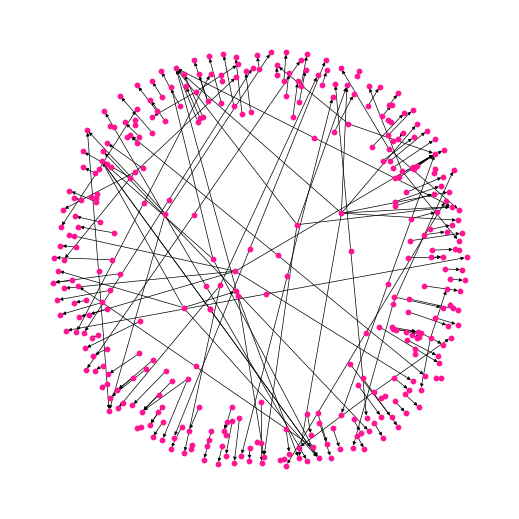

In [57]:
plt.figure(figsize=(5,5))
nx.draw(graph,  
        with_labels = False,
        node_color='deeppink',
        node_size=10,
        width=0.5,
        arrowsize=5,
        font_color="black",
        font_size=2)